# Introduction

The aim is to practice what I have learned:exploring the data, Imputing missing values,Label/one hot encoding categorical variables, random forest and XGBoosting models. I start from the basic and gradually improve the models. The mean_absolute_error has been decreased from 17,906 to 15,355.

My future work will be to improve the feature enginnering by Box Cox Transformation of skewed features, applied more models  and use the model ensambling 




# 1. Exploratory Data Analysis

* Each row in the dataset describes the characteristics of a house.
* Our goal is to predict the SalePrice, given these features.

In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

home_data = pd.read_csv('train.csv')
home_data_test=pd.read_csv('test.csv')

home_data.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
print('The traning data shape:')
print(home_data.shape)

print('The test data shape:')
print(home_data_test.shape)


The traning data shape:
(1460, 81)
The test data shape:
(1459, 80)


In [3]:
home_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1.1 Analyse the target: SalePrice

In [4]:
home_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There is no missing values from the target

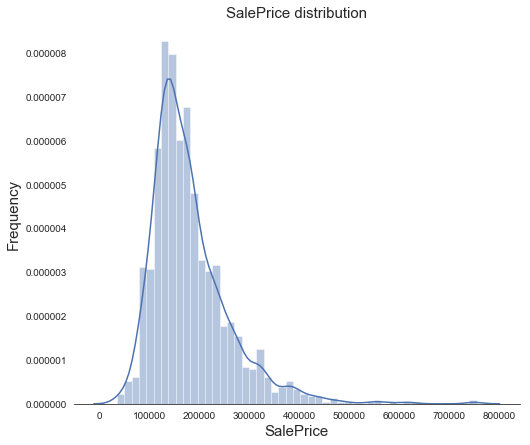

In [5]:
sns.set_style("white")#separate each bar
sns.set_color_codes('deep')#will change the blue to light blue
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(home_data['SalePrice'],color='b')
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xlabel("SalePrice",fontsize=15)
ax.set_title("SalePrice distribution",fontsize=15)
sns.despine(left=True)


The Sale price seems like a normal distribution, need to be converted to normal distribution when do the ML

In [6]:
#skewness and kurtosis
print("Skewness:{}".format(home_data['SalePrice'].skew()))
print("Kurtosis:{}".format(home_data['SalePrice'].kurt()))

Skewness:1.8828757597682129
Kurtosis:6.536281860064529


## 1.2 The relationship between Saleprice and Numerical Features

In [7]:
# Finding numeric features
numerical_features=[col for col in home_data.columns if home_data[col].dtypes!="object"]

In [8]:
home_data[numerical_features].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
home_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

scatter plot for all numerical features

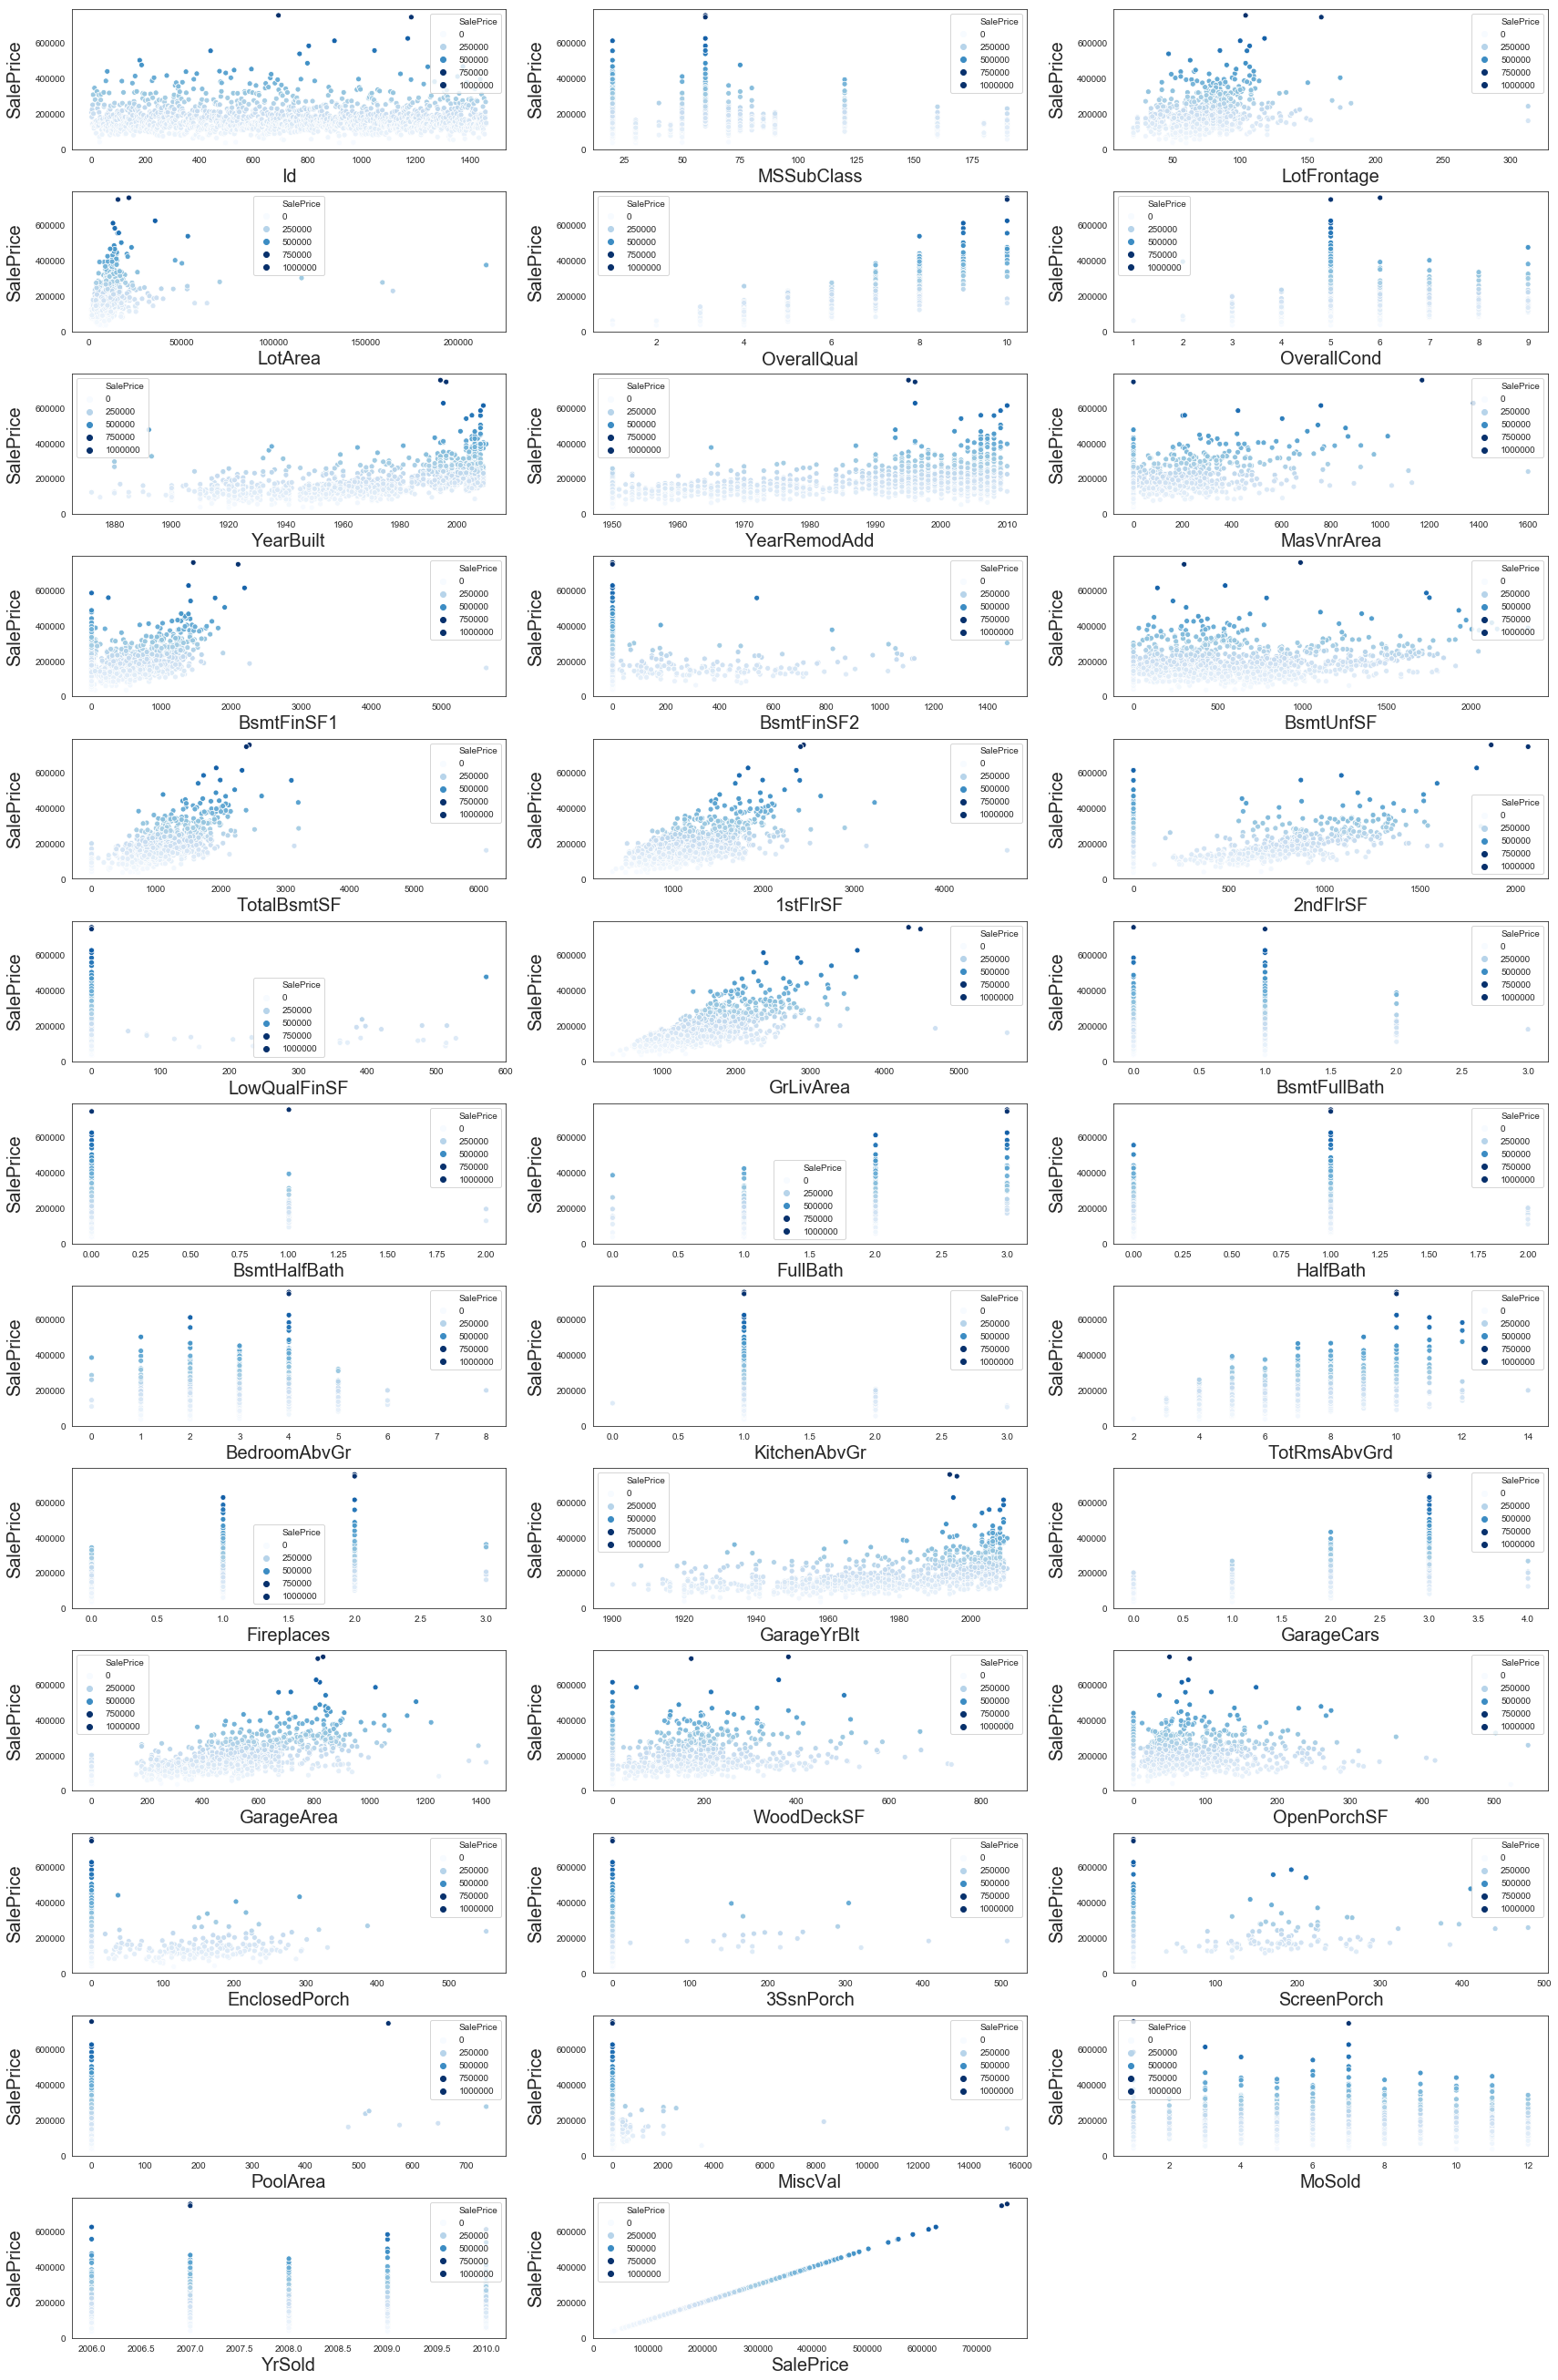

In [10]:

# visualising some more outliers in the data values   
plt.subplots(figsize=(12, 120))
plt.subplots_adjust(hspace=0.3,wspace=0.2,right=2,top=1)
for i, feature in enumerate(home_data[numerical_features], 1):#enumerate:print index and the relevant value
    plt.subplot(len(numerical_features), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=home_data)
        
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.ylabel('SalePrice', labelpad=12.5,fontsize=20)
    
    plt.legend(loc='best',prop={'size': 10})
        
plt.show()

## 1.3 The relationship between Numerical Features

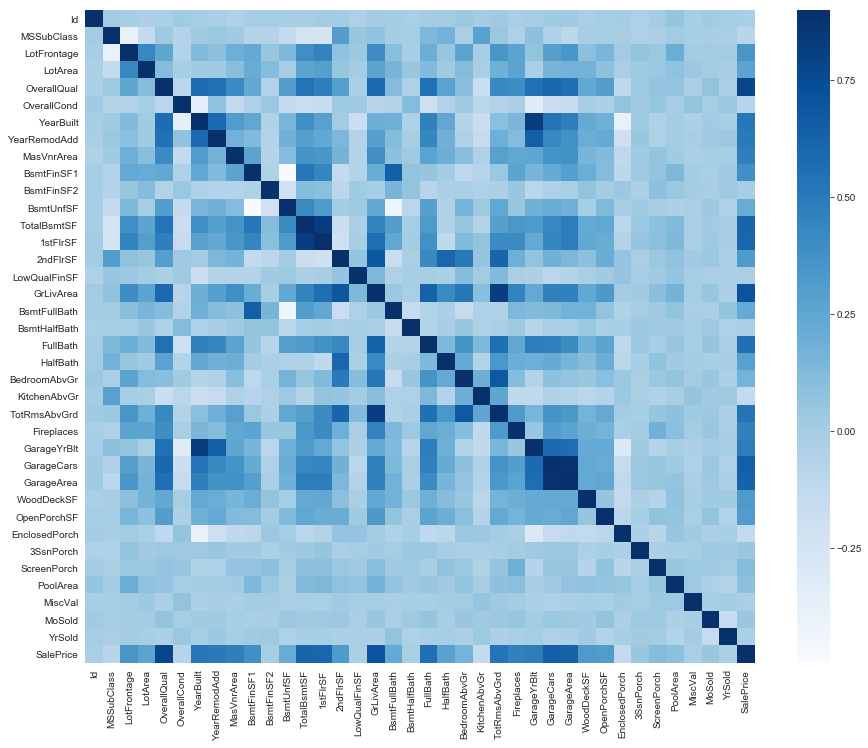

In [11]:
corr = home_data.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, cmap="Blues",vmax=0.9 )

The heatmap also indicates there are some features have the great effect on the SalePrice

# 2 Pridiction with Random Forest model

## 2.1  With features contain only not null numerical features 

In [12]:

# Create target object and call it y
y = home_data['SalePrice']
# Create X, choose all numerical deatures

X = home_data.drop(['SalePrice','Id'],axis=1).select_dtypes(exclude=['object']).dropna(axis=1)
features=X.columns

test_X = home_data_test[features].dropna(axis=1)
features_test=test_X.columns

X=X[features_test]

#find colums with Null
missing_value_by_columns=X.isnull().sum()
print(missing_value_by_columns[missing_value_by_columns>0])


# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(n_estimators=100,random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("MAE for Approach 1: {:,.0f}".format(rf_val_mae))


Series([], dtype: int64)
MAE for Approach 1: 17,906


## 2.2 Imputation: fills in the missing values with mean number along each column.

GarageYrBlt column (which indicates the year that the garage was built). It's likely that in some cases, a missing value could indicate a house that does not have a garage. so after tring with "mean", "median" and "most_frequent", "mean" can provide better results

In [13]:
X = home_data.drop(['SalePrice','Id'],axis=1).select_dtypes(exclude=['object'])
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=1)
missing=X_train.isnull().sum()
missing[missing>0]


LotFrontage    200
MasVnrArea       7
GarageYrBlt     54
dtype: int64

In [14]:


from sklearn.impute import SimpleImputer
imputer=SimpleImputer()
imputed_X_train=pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_val=pd.DataFrame(imputer.fit_transform(X_val))
# Imputation removed column names; put them back
imputed_X_train.columns=X_train.columns
imputed_X_val.columns=X_val.columns



In [15]:
#define a function to measure quality of each approach
def score_dataset(X_train,X_val,y_train,y_val):
    model=RandomForestRegressor(n_estimators=100,random_state=1)
    model.fit(X_train,y_train)
    predict=model.predict(X_val)
    return mean_absolute_error(y_val,predict)



In [16]:
print('MAE for approach 2 (Imputation):')
print(score_dataset(imputed_X_train,imputed_X_val,y_train,y_val))


MAE for approach 2 (Imputation):
16762.51723287671


## 2.3 Imputation extension : fills in the missing values with mean number along each column and also keeping track of which values were imputed.

In [17]:
X = home_data.drop(['SalePrice','Id'],axis=1).select_dtypes(exclude=['object'])
#identify which column has the null 
col_miss_value=[col for col in X.columns if X[col].isnull().any()]
# copy to avoid changing the original dataset
X_train_plus=X_train.copy()
X_val_plus=X_val.copy()
# add new column to track if values are imputed

for col in col_miss_value:
    X_train_plus[col+'_if_imputed']=X_train_plus[col].isnull()
    X_val_plus[col+'_if_imputed']=X_val_plus[col].isnull()
    
imputed_X_train_plus=pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_val_plus=pd.DataFrame(imputer.fit_transform(X_val_plus))

imputed_X_train_plus.columns=X_train_plus.columns
imputed_X_val_plus.columns=X_val_plus.columns  


print('MAE for approach 3 (Imputation Extension):')
print(score_dataset(imputed_X_train_plus,imputed_X_val_plus,y_train,y_val))


MAE for approach 3 (Imputation Extension):
16942.742639269407


Approach 2 is better. score is 16762.51723287671

## 2.4 Add features considering categorical variable by Pipeline
* imputes missing values in numerical data
* imputes missing values and applies a one-hot encoding to categorical data.

In [18]:
# clean the dataset
X_full = pd.read_csv('train.csv',index_col='Id')
X_test=pd.read_csv('test.csv',index_col='Id')

X_full.dropna(axis=0,subset=['SalePrice'],inplace=True)
y=X_full.SalePrice
X_full.drop(['SalePrice'],axis=1,inplace=True)

X_train_full,X_val_full,y_train,y_val=train_test_split(X_full,y,random_state=1)



In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#find the numerical col
numerical_col=[col for col in X_train_full.columns if X_train_full[col].dtypes in ['int64','float64']]
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')

#find the categorical col
categorical_col=[col for col in X_train_full.columns if X_train_full[col].nunique()<10 and X_train_full[col].dtypes=='object']
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

X_train=X_train_full[numerical_col+categorical_col].copy()
X_val=X_val_full[numerical_col+categorical_col].copy()


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_col),
        ('cat', categorical_transformer, categorical_col)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=1)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_val)

print('MAE:', mean_absolute_error(y_val, preds))

MAE: 16422.316520547945


In [20]:
#define which n_estimator is better
results={}
for i in range(1,12):
    model = RandomForestRegressor(50*i, random_state=1)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    
    results[i*50]=mean_absolute_error(y_val, preds)
print(results)

{50: 16738.444000000003, 100: 16422.316520547945, 150: 16458.05302283105, 200: 16428.311369863015, 250: 16432.238542465755, 300: 16413.973433789954, 350: 16461.873651663405, 400: 16381.397226027397, 450: 16368.673558599696, 500: 16367.582739726027, 550: 16399.71207970112}


import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(results.keys(),results.values())
plt.show()

By considering the catigorical value, the mean_absolute_error is reduced to 16399 when n_estimator is 500

## 3 Pridiction with XGBoost: train model with gradient boosting
the advantages: do not need to worry about missing values. As one of the ensemble methods, XGBoost goes through cycles to iteratively add models into an ensemble.

In [21]:
X_full = pd.read_csv('train.csv',index_col='Id')
X_test=pd.read_csv('test.csv',index_col='Id')


X_full.dropna(axis=0,subset=['SalePrice'],inplace=True)
y=X_full.SalePrice
X_full.drop(['SalePrice'],axis=1,inplace=True)

X_train_full,X_val_full,y_train,y_val=train_test_split(X_full,y,random_state=0)


In [22]:
#get columns with low cardinality <10 (will apply one-hot encode) 
#and high cardinality >10 (will apply label encode)
#do not worry about the numerical columns

col_one_hot=[col for col in X_train_full.columns if X_train_full[col].dtypes=='object' and X_train_full[col].nunique()<=10]
col_label=[col for col in X_train_full.columns if X_train_full[col].dtypes=='object' and X_train_full[col].nunique()>10]

# Make copy to avoid changing original data 
X_train_copy = X_train_full.copy()
X_val_copy = X_val_full.copy()
X_test_copy=X_test.copy()

#apply the label encode
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
for col in col_label:
    X_train_copy[col]=label_encoder.fit_transform(X_train_full[col])
    X_val_copy[col]=label_encoder.transform(X_val_full[col])
    
#apply the one hot encode
X_train = pd.get_dummies(X_train_copy)
X_val   = pd.get_dummies(X_val_copy)
X_test  = pd.get_dummies(X_test_copy)
#Align two objects on their axes with the specified join method for each axis Index.
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test.shape


(1459, 229)

In [23]:
from xgboost import XGBRegressor
XGB_model = XGBRegressor()
XGB_model.fit(X_train, y_train)
predictions = XGB_model.predict(X_val)
mae = mean_absolute_error(predictions,y_val)
mae

/Users/Josh1/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:00:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


16234.28488869863

Parameter Tuning( n_estimators: 100-1000;early_stopping_rounds=5; learning_rate: 0.05-0.1;n_jobs=4

In [24]:

XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, n_jobs=4)
XGB_model.fit(X_train, y_train,
              early_stopping_rounds=10, 
              eval_set=[(X_val, y_val)], 
              verbose=False)
predictions = XGB_model.predict(X_val)
mae = mean_absolute_error(predictions,y_val)
mae

/Users/Josh1/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:00:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


15355.201658818492

In [25]:
#use the model to predict 
preds_test=XGB_model.predict(X_test)
output=pd.DataFrame({'Id':X_test.index,
                   'SalePrice':preds_test})
output.to_csv('submission.csv',index=False)